In [1]:
## Import
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA
import statistics
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Classifiers and kernels
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector


In [260]:
clf_list = [KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(), SVC()]

clf_list == KNeighborsClassifier

False

In [272]:
class_2_num = {
                "Knn": 0, 
                "Dtree": 1, 
                "LG": 2,  
                "RF": 3,
                "SVM": 4
}

In [270]:
type(class_2_num)

dict

In [193]:
def scatterplot_distribution(Y,Y1,Y2,data,X1,X2,title):

    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)

    if type(X1) is np.array:
        X1 = pd.DataFrame(X1)
    if type(X2) is np.array:
        X2 = pd.DataFrame(X2)    
    
    title1 = title[0]
    title2  = title[1]
    
    colour = sns.color_palette("Set2")
    color1=colour[0]
    color2=colour[1]
    colormap = np.array([color1,color2])

    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(131)
    ax1.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
    ax1.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[Y],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    # ax2 = fig.add_subplot(132, sharex = ax1, sharey = ax1)
    ax2 = fig.add_subplot(132)
    ax2.set_title(title1 + f"={len(X1)}", fontsize=15)
    ax2.scatter(X1.iloc[:,0], X1.iloc[:,1], marker='o', c=colormap[Y1],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    # ax3 = fig.add_subplot(133, sharex = ax1, sharey = ax1)
    ax3 = fig.add_subplot(133)
    ax3.set_title(title2 + f"={len(X2)}", fontsize=15)
    ax3.scatter(X2.iloc[:,0], X2.iloc[:,1], marker='o', c=colormap[Y2],
            s=45, edgecolor='k', cmap=plt.cm.Paired)   

    GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
    LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
    fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
    fig.subplots_adjust(right=0.95)

    plt.show()
 
def get_data():
    data = load_data() 
    X = data
    X = X.replace(np.inf, np.nan)
    X.drop_duplicates(keep='first')
    X.columns.drop_duplicates(keep='first')
    Y = data['label']
    del X['label']
    print(f'Shape of data = {data.shape}, X = {X.shape} Y = {Y.shape}')
    print(f'Number of duplicated datasets = {X.duplicated().sum()}')
    print(f'Number of duplicated features = {X.columns.duplicated().sum()}')
    print(f'Number of infinite values = {X.isin([np.inf, -np.inf]).sum().sum()}')
    print(f'Number of NaN values = {X.isna().sum().sum()}')
    
    return data, X, Y

def split_data(X,Y):
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    print(f'shape of X train = {(X_train.shape)}, shape of X train = {(X_test.shape)}')
    print(f'shape of Y train = {(Y_train.shape)}, shape of Y train = {(Y_test.shape)}')
    
    return X_train, X_test, Y_train, Y_test

def remove_features(X_train, X_test):
    
    old_train = X_train.shape[1]
    old_test = X_test.shape[1]
    acceptabele_ratio = 0.5
    train_size = len(X_train.index)
    removal_rate = round(train_size*acceptabele_ratio)
    X_train = X_train.dropna(axis=1, thresh=removal_rate)

    test_size = len(X_test.index)
    removal_rate = round(test_size*acceptabele_ratio)
    X_test = X_test.dropna(axis=1, thresh=removal_rate)
    
    print(f'Shape of X train = {X_train.shape[1]}, shape of X train = {X_test.shape[1]}')
    print(f'{old_train-X_train.shape[1]} features have been removed from train; {old_test-X_test.shape[1]} features have been removed from test')

    del old_train, old_test
    return X_train, X_test    

def encoder(Y_train, Y_test):
    encoder = LabelEncoder()
    encoder.fit(Y_train)
    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)
    
    print(f'Values in Y train = {np.unique(Y_train)}, values in Y test {np.unique(Y_test)}')
    print(f'Shape of Y train = {(Y_train.shape)}, shape of Y train = {(Y_test.shape)}')

    return Y_train,Y_test

def preprocess_x(X_train,X_test):
    x_pipe = Pipeline([('imputer', KNNImputer()), ('scaler', RobustScaler()),('PCA', PCA(n_components=0.99, svd_solver= 'full'))])
    x_pipe.fit(X_train)

    X_train = x_pipe.transform(X_train)
    X_test = x_pipe.transform(X_test)

    print(f'Number of features after PCA: train set={X_train.shape[1]}; test set={X_test.shape[1]}')
    print(f'Number of NaN values: train ={np.isnan(X_train).sum().sum()}; test={np.isnan(X_test).sum().sum()}')

    return X_train, X_test

def classifier(k,mean):
    cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    results = pd.DataFrame()
    for train_index, validation_index, in cv_10fold.split(X_train, Y_train):

        X_train_CV = X_train[train_index]
        Y_train_CV = Y_train[train_index]

        X_validation_CV = X_train[validation_index]
        Y_validation_CV = Y_train[validation_index]

        clf = clf_list[k]
        parameters = parameters_list[k]
        randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
        randomized_search.fit(X_train_CV, Y_train_CV)

        # Get resulting classifier
        clf = randomized_search.best_estimator_
        parameters_results =clf.get_params()

        # Test the classifier on the train data
        probabilities = clf.predict_proba(X_train_CV)
        scores = probabilities[:, 1]
        accuracy = clf.score(X_train_CV, Y_train_CV)

        # Get the auc
        auc = metrics.roc_auc_score(Y_train_CV, scores)
        param_name = ['auc'] + ["accuracy"] + [item for item in parameters] + ['set']
        row = []
        row.append(auc)
        row.append(accuracy)
        for item in parameters:
            row.append(parameters_results[item])
        row.append('train')
        results = results.append(pd.Series(row, index = param_name), ignore_index=True)

        # Test the classifier on the validation data
        probabilities_validation = clf.predict_proba(X_validation_CV)
        scores_validation = probabilities_validation[:, 1]
        accuracy_validation = clf.score(X_validation_CV, Y_validation_CV)

        # Get the auc
        auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
        row = []
        row.append(auc_validation)
        row.append(accuracy_validation)
        for item in parameters:
            row.append(parameters_results[item])
        row.append('validation')

        results = results.append(pd.Series(row, index = param_name), ignore_index=True)

    #Create results dataframe and plot it
    results = pd.DataFrame(results)
    # sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[k]}')

    train_mean_auc = round(results[results['set']=='train']['auc'].mean(),2)
    train_mean_acc = round(results[results['set']=='train']['accuracy'].mean(),2)
    print(f"Train: mean AUC={train_mean_auc}, mean accuracy={train_mean_acc}")

    val_mean_auc = round(results[results['set']=='validation']['auc'].mean(),2)
    val_mean_acc = round(results[results['set']=='validation']['accuracy'].mean(),2)
    print(f"Validation: mean AUC={val_mean_auc}, mean accuracy={val_mean_acc}\n")

    mean.append({
        'AUC train' :train_mean_auc,
        'AUC val' :val_mean_auc,
        "AUC diff": train_mean_auc-val_mean_auc,
        'acc train': train_mean_acc,
        'acc val': val_mean_acc,
        "acc diff": train_mean_acc-val_mean_acc,
    })

    optimal_parameter = []
    parameter_keys = list(parameters.keys())

    for item in parameter_keys:
        best_item = []
        for i in list(range(0,10,2)):
            best_item.append(results[item][i])
        
        optimal_parameter.append(f"{item} = {statistics.median(best_item)}")
    
    print(f"Optimal parameter: {optimal_parameter}")

    return results, optimal_parameter, mean  


Shape of data = (167, 725), X = (167, 724) Y = (167,)
Number of duplicated datasets = 0
Number of duplicated features = 0
Number of infinite values = 0
Number of NaN values = 7797
shape of X train = (133, 724), shape of X train = (34, 724)
shape of Y train = (133,), shape of Y train = (34,)
Shape of X train = 704, shape of X train = 704
20 features have been removed from train; 20 features have been removed from test
Values in Y train = [0 1], values in Y test [0 1]
Shape of Y train = (133,), shape of Y train = (34,)
Number of features after PCA: train set=2; test set=2
Number of NaN values: train =0; test=0


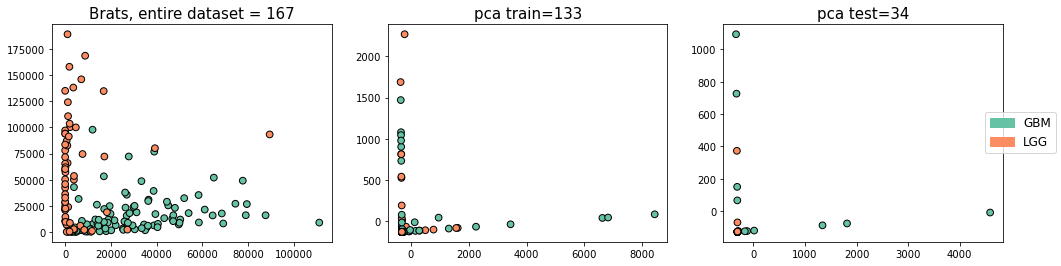

In [194]:
def all():
    data, X, Y = get_data()
    X_train, X_test, Y_train, Y_test = split_data(X,Y)
    X_train, X_test = remove_features(X_train, X_test)
    Y_train, Y_test = encoder(Y_train, Y_test)
    X_train, X_test = preprocess_x(X_train, X_test)
    
    return data, Y, X_train, X_test,Y_train, Y_test

data, Y, X_train, X_test,Y_train, Y_test = all()
title = ['pca train', 'pca test']
X2 = pd.DataFrame(X_train)
X3 = pd.DataFrame(X_test)
scatterplot_distribution(Y,Y_train, Y_test,data,X2, X3,title)

In [257]:
parameters_list = [
        {
                    "n_neighbors": [0,1,2,3,4,5,6,7,8,9,10],
                     "weights": ["uniform", "distance"],
        },
        {
                    "criterion": ['gini', 'entropy'],
                    "min_samples_split": list(range(2,40,2)),
                     "max_features": [1,2,3,4],
                     "min_samples_leaf": list(range(1,20,2)),
        },
        {
                     'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                     'penalty' :["l1", 'l2', 'elasticnet', 'none'],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        },
        {
                    "n_estimators" : range(80,500,2),
                #      "criterion": ['gini', 'entropy'],
                #      "min_samples_split": list(range(2,40,2)),
                #     "max_features": [1,2,3,4],
                #      "min_samples_leaf": list(range(1,20,2)),
        },
        {
            
        },
]

In [258]:
results, optimal_parameter, mean_lg = classifier(3, mean_rf)
mean = pd.DataFrame(mean_rf)
mean

Train: mean AUC=0.84, mean accuracy=0.75
Validation: mean AUC=0.68, mean accuracy=0.66

Optimal parameter: ['n_estimators = 220.0', 'criterion = gini', 'min_samples_split = 12.0', 'max_features = 2.0', 'min_samples_leaf = 5.0']


,AUC train,AUC val,AUC diff,acc train,acc val,acc diff
0,1.00,0.66,0.34,1.00,0.65,0.35
1,1.00,0.69,0.31,1.00,0.64,0.36
2,0.84,0.68,0.16,0.75,0.66,0.09


In [253]:
mean_rf = []
mean= mean_r

In [209]:
#LG
# results, optimal_parameter, mean_lg = classifier(3, mean_lg)
# mean = pd.DataFrame(mean_rf)
# mean

#RF
# results, optimal_parameter, mean_lg = classifier(3, mean_rf)
# mean = pd.DataFrame(mean_rf)
# mean

# Dtree
# results, optimal_parameter, mean_dtree = classifier(1, mean_dtree)
# mean = pd.DataFrame(mean_dtree)
# mean


Train: mean AUC=1.0, mean accuracy=1.0
Validation: mean AUC=0.67, mean accuracy=0.64

Optimal parameter: ['n_estimators = 107.0']


,AUC train,AUC val,AUC diff,acc train,acc val,acc diff
0,1.0,0.66,0.34,1.0,0.63,0.37
1,1.0,0.67,0.33,1.0,0.64,0.36


In [200]:
mean_dtree = []
mean_lg = []
mean_rf = []

In [ ]:
# def knn(n,w):
#     cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#     cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#     results = []

#     for train_index, validation_index, in cv_10fold.split(X_train, Y_train):

#         X_train_CV = X_train[train_index]
#         Y_train_CV = Y_train[train_index]

#         X_validation_CV = X_train[validation_index]
#         Y_validation_CV = Y_train[validation_index]

#         clf = KNeighborsClassifier(n_neighbors=n, weights=w)
#         clf.fit(X_train_CV, Y_train_CV)

#         probabilities = clf.predict_proba(X_train_CV)
#         scores = probabilities[:, 1]
#         accuracy = clf.score(X_train_CV, Y_train_CV)
        

#         # Get the auc
#         auc = metrics.roc_auc_score(Y_train_CV, scores)
#         results.append({
#             'auc': auc,
#             'accuracy': accuracy,
#             "set": "train"
#         })

#         # # Test the classifier on the validation data
#         # probabilities_validation = clf.predict_proba(X_validation_CV)
#         # scores_validation = probabilities_validation[:, 1]

#         # # Get the auc
#         # auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
#         # results.append({
#         #     'auc': auc_validation,
#         #     "set": "validation"
#         # })

#         # results 

#     #Create results dataframe and plot it
#     results = pd.DataFrame(results)
#     return results
